## Get started
### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from os.path import exists, dirname
import os, sys
import numpy as np
import seaborn as sns
import json
path = os.path.dirname((os.path.abspath('')))
print(path)
sys.path.append(path)
from dreem_nap.study import Study
import yaml

/Users/ymdt/src/dreem_nap


/Users/ymdt/src/dreem_nap/venv-nap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configuration
- Load config file and check what's in it
- Configurate the Notebook

In [2]:
with open('../config.yml', 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
for k,v in cfg.items():
    print(k,(30-len(k))*'_',v)

mpl.rcParams['figure.dpi'] = cfg['mpl_rcParams_figure_dpi'] # the highest the resolution, the slowest the plotting


path_to_data __________________ /Users/ymdt/src/data/Lauren
path_to_studies _______________ /Users/ymdt/src/data/Lauren/studies.csv
min_cov_bases _________________ 1000
mpl_rcParams_figure_dpi _______ 100


### Load data
Create and load dataframe of a single study as a demo

In [3]:
path = os.path.dirname((os.path.abspath('')))
print(path)
sys.path.append(path)
from dreem_nap.study import Study

# Create a study
salt = Study.from_dict({'name': 'salt',
                         'description': 'Change the Na concentration', 
                         'samples': ['A6', 'B6', 'C6', 'D6', 'E6'], 
                         'label': 'Na quantity [M]', 
                         'conditions': [0.15, 0.3, 0.6, 1.0, 1.2]})

# Load data
salt.load_df_from_local_files(path_to_data= cfg['path_to_data'], 
                              min_cov_bases= cfg['min_cov_bases'])#,
                            #  index='roi')

# Show the dataframe
salt._df.head()

/Users/ymdt/src/dreem_nap


AssertionError: /Users/ymdt/src/data/Lauren/A6.p does not exist.

In [9]:
#! usr/bin/env python3

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from os.path import exists, dirname
import os, sys
import numpy as np
import seaborn as sns
import json

path = '/Users/ymdt/src/dreem_nap/'

sys.path.append(path)
from dreem_nap.manipulator import Manipulator

from dreem_nap.study import Study, util
import yaml
import pickle

#mpl.use('agg')

with open(path+'config.yml', 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

mpl.rcParams['figure.dpi'] = cfg['mpl_rcParams_figure_dpi'] # the highest the resolution, the slowest the plotting

####
# SET HYPER PARAMETERS HERE
####

studies = Study.load_studies(cfg['path_to_studies'])
study = Study.from_dict(studies['3UTR_v_5UTR'].__dict__)
study.load_df_from_local_files(path_to_data= cfg['path_to_data'], min_cov_bases = cfg['min_cov_bases'], filter_by='sample')
study._df.head()

100%|██████████| 628/628 [00:00<00:00, 23419.78construct filtered/s, sample:472]


,samp,construct,sequence,structure,data_type,num_reads,num_aligned,num_of_mutations,mut_bases,info_bases,...,skips_short_read,skips_too_many_muts,mod_bases_A,mod_bases_C,mod_bases_G,mod_bases_T,cluster,mut_rates,worst_cov_bases,min_cov_bases
0,470,3114-O-flank_1=hp7-DB,TTAAACCGGCCAACATACCGCATATGAGGATCACCCATATGCTCGC...,......(((........)))((((((.((....))))))))...((...,DMS,2028,2017,"[466, 590, 423, 196, 82, 20, 5, 11, 5, 2, 0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1806.0, 1936.0, 1948.0, 2000.0, 2008.0, 2010....",...,0,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",1792.0,1000
1,470,3482-O-flank_1=lp11-DB,TTAAACCGGCCAACATACCGCATATGAGGATCACCCATATGCTCTC...,......(((........)))((((((.((....))))))))........,DMS,2934,2932,"[818, 851, 559, 219, 74, 26, 5, 2, 1, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[2693.0, 2838.0, 2852.0, 2919.0, 2925.0, 2927....",...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000341646737273659...",2127.0,1000
2,470,3091-CC-flank_1=hp5-DB,TTAAACCGGCCAACATACCGCATATGAGGATCACCCATATGCTCGC...,......(((........)))((((((.((....))))))))...((...,DMS,2800,2797,"[722, 818, 574, 254, 86, 30, 8, 7, 2, 3, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[2545.0, 2686.0, 2700.0, 2784.0, 2792.0, 2793....",...,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00035790...",2361.0,1000
3,470,3124-O-flank_1=hp7-DB,TTAAACCGGCCAACATACCGCATATGAGGATCACCCATATGCTCCG...,......(((........)))((((((.((....))))))))........,DMS,2790,2700,"[587, 670, 566, 341, 143, 56, 18, 7, 3, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[2388.0, 2530.0, 2550.0, 2596.0, 2605.0, 2607....",...,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003834355828...",2328.0,1000
4,470,3546-O-flank_1=bi4-rre-DB,TTAAACCGGCCAACATACCGCATATGAGGATCACCCATATGCTCCG...,......(((........)))((((((.((....))))))))...((...,DMS,1471,1468,"[307, 423, 324, 182, 84, 22, 6, 5, 3, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1342.0, 1414.0, 1424.0, 1455.0, 1460.0, 1461....",...,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1327.0,1000


In [28]:
from scipy.cluster import hierarchy

data = np.array(study.mani.get_col_across_constructs(samp=470, 
                                          col='mut_rates',
                                          index='CACAGTCGAAAGACTGTG'))
def compute_smilitude_score(x,y, type='euclidean'):
    if type == 'euclidean':
        return 2*np.linalg.norm(x-y)/(np.linalg.norm(x)+np.linalg.norm(y))

N = data.shape[0]
out = np.array([[compute_smilitude_score(data[i],data[j]) for i in range(j+1,N)] for j in range(N)])
hierarchy.fclusterdata(data, t=0.01, criterion='distance', metric='euclidean')
        

/var/folders/00/r1kkxj7d0k344frrqtzrc5000000gn/T/ipykernel_56266/3203252645.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([[compute_smilitude_score(data[i],data[j]) for i in range(j+1,N)] for j in range(N)])


array([  3, 206, 120,  80, 145,  80,  80,  80,  80,   8,  79,  80,  80,
        80, 188, 104,  80, 233, 191,  80,  80,  35, 176,  80, 136,  80,
        80,  80,  45,  80, 122,  80,  80, 221, 223, 171,  80, 151,  80,
        80,  71,  80, 116,  80,  80, 142, 107, 166,  33, 119,  80,  80,
       157, 234,  80, 195, 225,  80,  75,  80,  80,  80,  80,  80,  80,
       190, 219, 159,  80,  51,  58,  80,  80,  80, 155, 153,  84,  80,
        39,  18, 177,  31, 110,  24,  80,  80, 133,  80, 187,  80,  80,
       210,  28,  92,  80,  80,  80,  80, 158,  12,  80,  80, 117,  80,
       139,  36,  80,  80,  72,  80, 226, 194,  80,  80,  80,   1,  20,
       160,  13, 184,  80, 167,  87,  80, 127,  80,  80, 216,  70,  80,
       137, 208,  80, 192, 229, 128,  80,  49,  80,  80,  80,  80,  64,
        45,  80,  80,  80,  80,  80,  54,  80,  80, 162, 149,  80,  66,
       156,  22,  80,  80,  80, 189,  80, 109,  80, 129,  80, 224,  80,
        26,  80,  80,  80,  80,  29, 114,  99,  85,  80,  80,  8

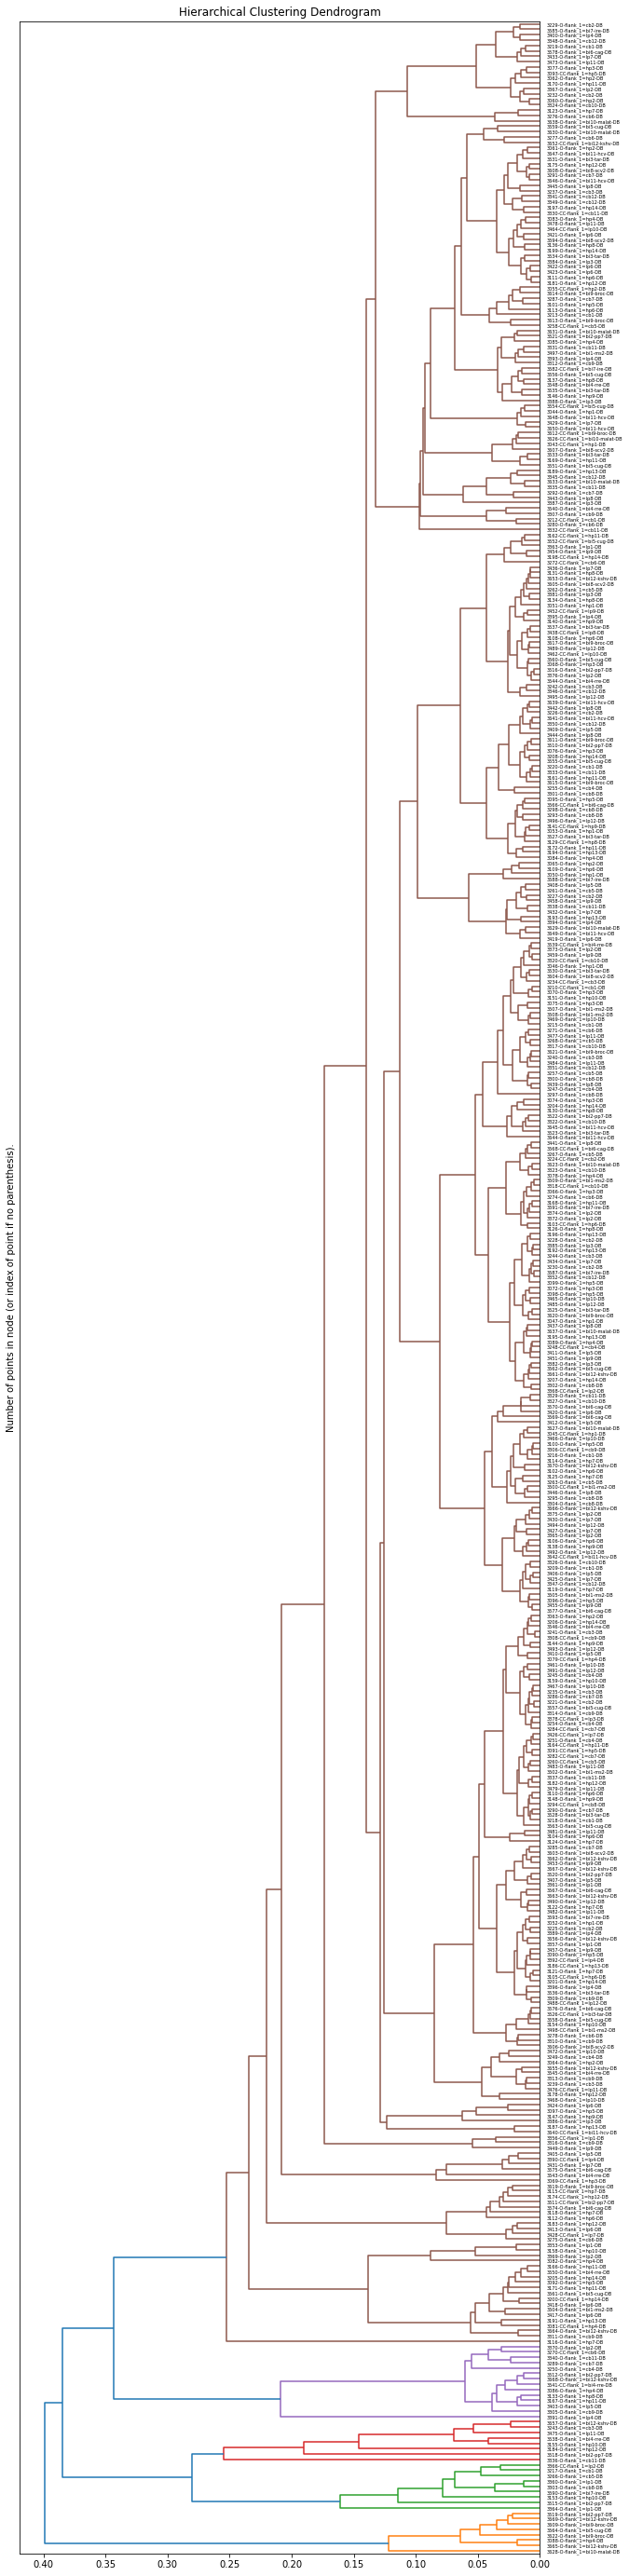

In [85]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

def mut_histogram(self, samp:str, construct:str, cluster:int=0, plot_type:str='index', index='all', base_type:List[str]=['A','C','G','T'], base_paired:bool=None, structure:str=None, show_ci:bool=True, figsize:Tuple[int]=(35,7), **kwargs)->OutputPlot:
    """Plot the mutation rates as histograms.

    Args:
        samp (str): Sample of your sample-construct-cluster.
        construct (str): Construct of your sample-construct-cluster.
        cluster (int, optional): Cluster of your sample-construct-cluster. Defaults to 0. 
        plot_type (str, optional): Colors of the bars.

            * ``'index'`` (default) uses bases numbers as index and the original construct bases as colors.
            * ``'partition'`` uses original sequence bases as index and the partition of mutated bases as colors.
        index (_type_, optional): Indexes to plot. Defaults to ``'all'``.
        base_type (List[str], optional): Bases type to plot. Defaults to ``['A','C','G','T']``.
        base_paired (bool, optional): Base-pairing predicition to plot. Defaults to None.
        structure (str, optional): Structure to use for base_paired filtering. Defaults to None.
        show_ci (bool, optional): Show confidence interval on the histogram. Defaults to True.
        figsize (Tuple[int], optional): Figure size. Defaults to (35,7).
        **kwargs: Other arguments to pass to matplotlib.pyplot.
        """
        
def dendrogram()

    def plot_dendrogram(model, **kwargs):
        # Create linkage matrix and then plot the dendrogram

        # create the counts of samples under each node
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)
        for i, merge in enumerate(model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[i] = current_count

        linkage_matrix = np.column_stack(
            [model.children_, model.distances_, counts]
        ).astype(float)
        # Plot the corresponding dendrogram
        hierarchy.dendrogram(linkage_matrix, labels=model.labels_,**kwargs)


    data = study.mani.get_col_across_constructs(samp=470, 
                                            col='mut_rates',
                                            index='CACAGTCGAAAGACTGTG')

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(data)
    plt.figure(figsize=(10,50))
    model.labels_ = [data.index[int(i)] for i in model.labels_]

    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", orientation='left')

    plt.ylabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

In [45]:
pd.DataFrame(model.children_).sort_values(by=0).to_csv('test.csv', index=False)

In [11]:
df = study.mani.get_SCC(samp=470,
                        construct='3114-O-flank_1=hp7-DB', 
                        cols=['mut_rates','sequence','structure','cov_bases'],
                        base_type=['A','C'], 
                        index=list(range(40,50))) 
df.to_csv('example.csv')

In [20]:
from dreem_nap import util
sub_lib = 'ART5'
mpl.use('agg') # use this to avoid display issues
for samp in study.samples:
    for construct in study.constructs:
        df = study.get_df()
        if df[(df['samp']==samp)&(df['construct']==construct)]['sub-library'].iloc[0] == sub_lib:
            study.plot.mut_histogram(samp=samp,construct=construct)
           # util.save_fig(path_to_figs+'/'+study.name+'/'+samp+'_'+construct+'_mut_histogram.png')

/Users/ymdt/src/dreem_nap/dreem_nap/plotter.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


KeyboardInterrupt: 

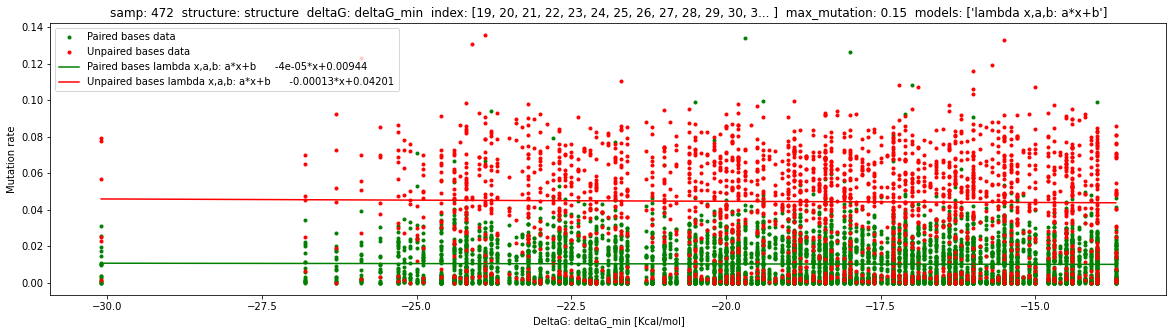

In [57]:
study.plot.deltaG_sample(samp=472, 
                         structure='structure', 
                         deltaG='deltaG_min', 
                         max_mutation=0.15, 
                         models=['lambda x,a,b: a*x+b'], 
                         index=list(range(19,42)))


In [53]:
study._df['flank'].unique()

array(['flank_1'], dtype=object)

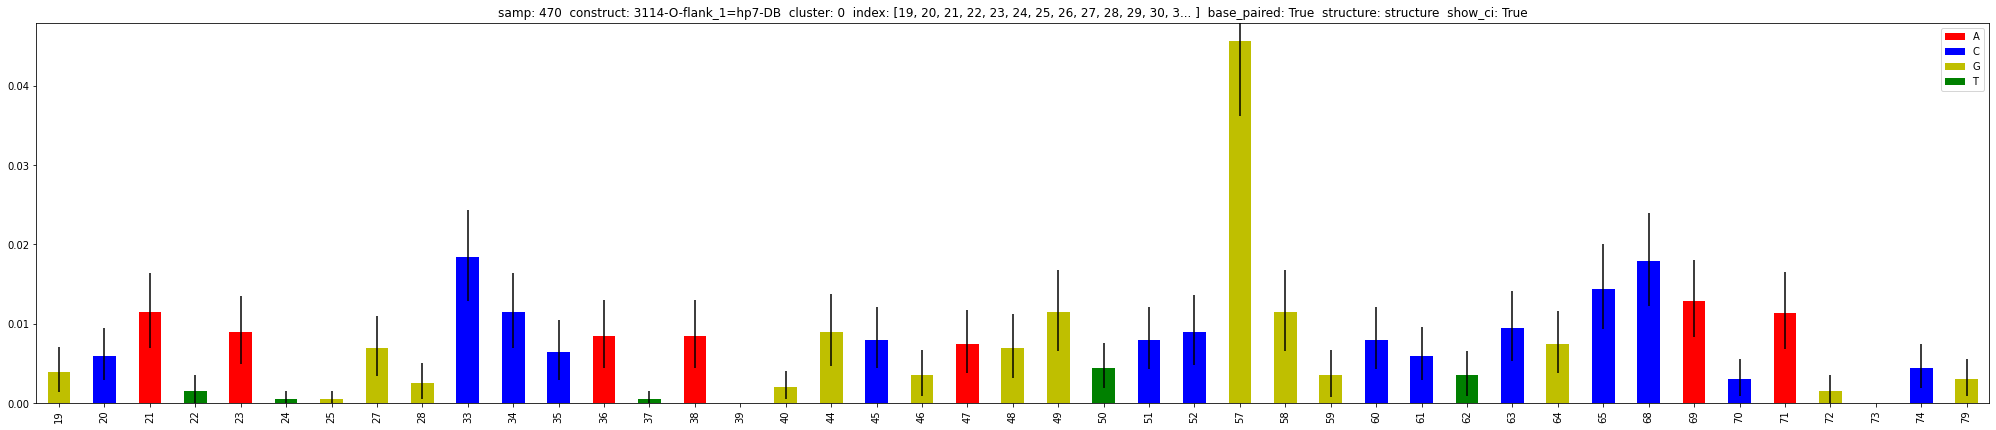

In [61]:
study.plot.mut_histogram(samp=470,
                         construct='3114-O-flank_1=hp7-DB',
                         cluster=0,
                         index=list(range(19,80)),
                         base_paired=True,
                         structure='structure')

In [1]:

salt.plot.mut_histogram(samp=470, construct='3114-O-flank_1=hp7-DB', base_paired=False, structure='structure')#, base_type=['A','C'])#index=list(range(19,42)))


NameError: name 'salt' is not defined

In [ ]:
base_type = list('ACTG')
figsize=(10,5)
colors = {'A':'r','C':'b','G':'y','T':'g'}
samp=470
construct='3114-O-flank_1=hp7-DB'
index='CACAGTCGAAAGACTGTG'
args = locals()
args.pop('df')
fig = plt.figure(figsize=figsize)
ax = plt.axes()
df_hist = pd.DataFrame()




In [ ]:
min_base_cov = 1000
studies = Study.load_studies(cfg['path_to_studies'])
study = Study().from_dict(studies['all'].__dict__)
study.load_df_from_local_files(path_to_data= cfg['path_to_data'], min_cov_bases =min_base_cov, filter_by='sample')
for s in study.samples:
    study.plot.deltaG_sample(samp=s, index = list(range(19,42)), base_type=['A','C'], structure='structure',deltaG='deltaG_min',figsize=(25, 7), grid=True, cluster=0, models=['lambda x, a, b, c: a+2*b*(np.exp(c*x)/(1+np.exp(c*x)))'])
    util.save_fig(f"/Users/ymdt/src/data/figs/Lauren/date/deltaG sample/min_base_cov = {min_base_cov}/index 19-41/{s}.png")


In [ ]:
df = study.get_df()

print('base_coverage | # constructs 470 | # constructs 472')
for min_base_cov in [5000, 4000, 3000, 2000,  1000, 500 ]:
    stu = Study().from_dict(studies['3UTR_v_5UTR'].__dict__)
    stu.load_df_from_local_files(path_to_data= cfg['path_to_data'], min_cov_bases = min_base_cov, filter_by='sample')
    df = stu.get_df()
    print(min_base_cov,sum(df.samp==470), sum(df.samp==472))
    for s in df.samp.unique():
        for c in df[df['samp']==s].construct.unique():
            stu.plot.mut_histogram(samp=s, construct=c, plot_type='index', index = 'CACAGTCGAAAGACTGTG', figsize=(25, 7), grid=True, cluster=0)
            util.save_fig(f"/Users/ymdt/src/data/figs/Lauren/date/mutation histograms/{min_base_cov}/{s}/{c}.png")


In [ ]:
lambda x, a, b, c: a+2*b*(np.exp(c*x)/(1+np.exp(c*x)))

In [ ]:
study.mani.get_SCC(samp=s, construct=c, cols=['mut_rates'], index = 'CACAGTCGAAAGACTGTG', base_type=['A','C'], structure='structure',  cluster=0)

In [ ]:
out = study.plot.mut_histogram(samp=470, construct='3114-O-flank_1=hp7-DB', plot_type='index', index = list(range(19,42)), figsize=(25, 7), grid=True)
print(out.data.to_csv('hi_lauren.csv'))

In [ ]:
stack = pd.DataFrame()
for c in study.constructs:
    stack = pd.concat((stack, pd.DataFrame(study.mani.get_SCC(samp=470, construct=c, cols=['mut_rates'], index=list(range(19,42))).T)))#, index=[c])))
stack.index = study.constructs
stack

## Make plots
Plot this study with different plots. Check out the list of plots in the plot module

### Mutation histogram

In [ ]:
salt.mut_histogram(samp='A6', construct='7695',\
             plot_type='index', figsize=(28,4))

### DeltaG
DeltaG vs mutation rate for all constructs of a sample

In [ ]:
salt.deltaG(samp='A6',bases_type=['A','C'], roi_range='all')  # currently bugged due to DREEM, work in progress

### DeltaG_basewise
Plot the mutation rate of each paired-predicted base of the ROI for each construct of a sample, w.r.t the deltaG estimation

In [ ]:
salt.deltaG_basewise(samp='A6', roi_range=[94,95,96,97])

###  Heatmap
Here a heatmap of the minimum base coverage across all samples. Column can be any column that contains a single scalar value.

In [ ]:
salt.heatmap(column='min_cov_bases') 

### Mutation rate vs 1-base_pairing
Plot a mutation rate histogram, a 1-base_pairing probability histogram, and a scatter plot fitting the mutation rate vs 1-base_pairing. 

In [ ]:
# currently bugged due to DREEM, work in progress
salt.mut_rate_vs_base_non_pairing_prob(samp='A6', construct='7695') # shows the mutation rate vs base non-pairing probability

### Base coverage
Plot the base coverage of a specific (sample, construct)

In [ ]:
salt.base_coverage(samp='A6', construct='9572')

### Base coverage for all constructs
Plot the base-coverage of the worst-covered base of the Region of Interest, for each construct. 

In [ ]:
salt.base_coverage_ROI_for_all_constructs()


In [ ]:
salt.random_9_base_coverage()

In [ ]:
random_9_base_coverage()
sample_coverage_distribution()
valid_construct_per_sample()
sliding_window_r2_gini()
study_base()
study_sample()
base_wise_mut_vs_prob()
correlation_n_samples()


In [ ]:
salt.study_base(construct='9572', structure='full',
                roi_range=[40,63,78,94])

### You can load every study from a file using Study.load_studies()

In [ ]:
studies = Study.load_studies(cfg['path_to_studies'])
for study in studies.values():
    if study.name != 'all_samples':
        study.load_df_from_local_files(path_to_data= cfg['path_to_data'], 
                                   min_cov_bases= cfg['min_cov_bases'])

studies['temperature'].df.head()

### Studies can be called from the dictionary using their name

In [ ]:
studies['temperature'].mut_histogram(studies['temperature'].samples[0], '9572', 'index')

In [ ]:
for study in studies.values():
    if study.name != 'all_samples':
        for s in study.samples:
            for construct in study.constructs:
                study.mut_histogram(s, construct, 'index')
                util.save_fig(f"data/figs/date/mutation histogram/{study.name}/{s}/{construct}.png")
                plt.close()


In [ ]:
class TestStudy(Study):
    def mut_histogram(self, samp:str, construct:str, plot_type:str, figsize=(35,7))->None:
        """Plot the mutation rate of a specific (sample, construct).

        Args:
        plot_type: 'index' or 'partition'. 
            - 'index' uses bases numbers as index and the original construct bases as colors.
            - 'partition' uses original sequence bases as index and the partition of mutated bases as colors.
        samp: sample of interest.
        construct: construct of interest.
        """

        df_use = self.df.set_index(['samp','construct'])
        
        if not plot_type in ['index','partition']:
            raise Exception(f"{plot_type} must be 'index' or 'partition', please check this argument")

        if plot_type == 'index':  # Plot the mutation rate for each base along the sequence

            mut_per_base = pd.DataFrame({'mut_rates': df_use['mut_rates'].loc[samp, construct]
                                        ,'base':list(df_use['sequence'].loc[samp, construct])})\
                                        .reset_index()\
                                        .set_index(['base', 'index'])
            df_hist = pd.DataFrame()
            df_hist.index = mut_per_base.reset_index()['index']

            for base in ['A','C','G','T']:
                df_hist[base] = pd.Series(dtype=float)
                df_hist[base] = mut_per_base.loc[base]

            #df_hist.index = mut_per_base.reset_index()['base']

            ax = df_hist.plot.bar(stacked=True, color=['r','b','y','g'],  figsize=figsize)
            plt.title(f"sample {samp}, construct {construct}")

        if plot_type == 'partition': # Plot the partition of mutations for each base along the sequence
            df_hist = pd.DataFrame()
            for base in ['A','C','G','T']:
                df_hist[f"mod_bases_{base}"]  = np.array(df_use[f"mod_bases_{base}"].loc[samp, construct][1:])/df_use['info_bases'].loc[samp, construct][1:]

            df_hist.index = list(df_use['sequence'].loc[samp,construct])

            ax = df_hist.plot.bar(stacked=True, color=['r','b','y','g'], figsize=figsize)

        return ax


# Load configuration
with open('config.yml', 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
for k,v in cfg.items():
    print(k,(30-len(k))*'_',v)

mpl.rcParams['figure.dpi'] = cfg['mpl_rcParams_figure_dpi'] # the highest the resolution, the slowest the plotting

# Create a study
salt = TestStudy().from_dict({'name': 'salt',
                         'description': 'Change the Na concentration', 
                         'samples': ['A6', 'B6', 'C6', 'D6', 'E6'], 
                         'title': 'Na quantity [M]', 
                         'conditions': [0.15, 0.3, 0.6, 1.0, 1.2]})

# Load data
salt.load_df_from_local_files(path_to_data= cfg['path_to_data'], 
                              min_cov_bases= cfg['min_cov_bases'])

# Show the dataframe
salt.df.head()

In [ ]:
import pickle
from os import listdir

listdir('../data/DEMULTIPLEXED/')

with open(f"../data/DEMULTIPLEXED/A4/mh.p",'rb') as f:
    pick =pickle.load(f)
    print(dir(pick['9572']))


In [ ]:
for s in salt.samples:
    salt.mut_histogram(s, '9572', 'index')